# Creation and simulation of a malaria model with interventions

Model adapted from: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10733109/

### Load dependencies

In [1]:
import os
import json
import sympy
import torch
import numpy as np
import pandas as pd
from typing import Dict, List, Callable

# MIRA modeling dependencies
from mira.metamodel import *
from mira.metamodel.ops import stratify
from mira.examples.concepts import susceptible, exposed, infected, recovered
from mira.modeling import Model
from mira.modeling.amr.petrinet import AMRPetriNetModel, template_model_to_petrinet_json
from mira.sources.amr.petrinet import template_model_from_amr_json
from mira.metamodel.io import model_to_json_file, model_from_json_file

# PyCIEMSS dependencies
import pyciemss
import pyciemss.visuals.plots as plots
import pyciemss.visuals.vega as vega
import pyciemss.visuals.trajectories as trajectories
from pyciemss.integration_utils.intervention_builder import (
    param_value_objective,
    start_time_objective,
)

# Build malaria (host-vector disease) model with MIRA

### Define units

In [2]:
person_units = lambda: Unit(expression=sympy.Symbol('person'))
mosquito_units = lambda: Unit(expression=sympy.Symbol('mosquito'))
day_units = lambda: Unit(expression=sympy.Symbol('day'))
per_day_units = lambda: Unit(expression=1/sympy.Symbol('day'))
dimensionless_units = lambda: Unit(expression=sympy.Integer('1'))

### Define model concepts

In [3]:
c = {
    # human population
    "Sh": Concept(name="Sh", units=person_units(), identifiers={"ido": "0000514"}),
    "Eh": Concept(name="Eh", units=person_units(), identifiers={"apollosv": "0000154"}),
    "Ih": Concept(name="Ih", units=person_units(), identifiers={"ido": "0000511"}),
    "Rh": Concept(name="Rh", units=person_units(), identifiers={"ido": "0000592"}),
    "Dh": Concept(name="Dh", units=person_units(), identifiers={"ncit": "C28554"}),

    # mosquito population (aquatic stage)
    "G": Concept(name="G", units=mosquito_units()), # eggs
    "L": Concept(name="L", units=mosquito_units()), # larvae
    "P": Concept(name="P", units=mosquito_units()), # pupae

    # mosquito population (adult stage)
    "Sm": Concept(name="Sm", units=mosquito_units()), # susceptible mosquito
    "Em": Concept(name="Em", units=mosquito_units()), # exposed mosquito
    "Im": Concept(name="Im", units=mosquito_units()), # infectious mosquito
}

for concept in c:
    c[concept].name = concept

### Define model parameters with uncertainty

In [4]:
1/28

0.03571428571428571

In [5]:
I0_guess = 220
parameters = {
    # transition rates for human population
    'beta': Parameter(name='beta', value=sympy.Float(0.0044), units=per_day_units(),
                      distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 0.004,
                                                            'maximum': 0.005})),  # Transmission rate Sh -> Ih

    'I0': Parameter(name='I0', value=sympy.Float(I0_guess), units=per_day_units(),
                     distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 0.95*I0_guess,
                                                            'maximum': 1.05*I0_guess})),  # Initial value for Ih
    
    'rho': Parameter(name='rho', value=sympy.Float(0.1), units=per_day_units(),
                     distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 0.033,
                                                            'maximum': 0.14})),  # Rate of progressing Eh -> Ih
    
    'gamma': Parameter(name='gamma', value=sympy.Float(0.07), units=per_day_units()),  # Rate of progressing Ih -> Rh

    'mu': Parameter(name='mu', value=sympy.Float(0.0028), units=per_day_units(),
                 distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 0.0025,
                                                            'maximum': 0.003})),  # Death rate Ih -> Dh
    
    'phi': Parameter(name='phi', value=sympy.Float(0.005), units=per_day_units(),
                 distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 0.004,
                                                            'maximum': 0.006})),  # Rate of immunity loss Rh -> Sh
    
    # transition rates for mosquito population 
    'bm': Parameter(name='bm', value=sympy.Float(1.0), units=per_day_units()),  # Per capita oviposition rate of female mosquitoes

    'KG': Parameter(name='KG', value=sympy.Float(15_000), units=per_day_units(),
                 distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 14_900,
                                                            'maximum': 15_500})),  # Carrying capacity for eggs

    'KL': Parameter(name='KL', value=sympy.Float(10_000), units=per_day_units(),
                 distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 9500,
                                                            'maximum': 10_500})),  # Carrying capacity for larvae

    'KP': Parameter(name='KP', value=sympy.Float(7000), units=per_day_units(),
                 distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 6500,
                                                            'maximum': 7500})),  # Carrying capacity for pupae

    'tau': Parameter(name='tau', value=sympy.Float(0.03), units=per_day_units()),  # Hatch rate G -> L

    'nu': Parameter(name='nu', value=sympy.Float(0.005), units=per_day_units()),  # Rate L -> P

    'eps': Parameter(name='eps', value=sympy.Float(0.002), units=per_day_units()),  # Rate P -> Sm

    'dG': Parameter(name='dG', value=sympy.Float(0.028), units=per_day_units()),  # Natural death rate of eggs
    'dL': Parameter(name='dL', value=sympy.Float(0.07), units=per_day_units()),  # Natural death rate of larvae
    'dP': Parameter(name='dP', value=sympy.Float(0.03), units=per_day_units()),  # Natural death rate of pupae
    
    'eta': Parameter(name='eta', value=sympy.Float(0.011), units=per_day_units()),  # Death rate of adult mosquitoes

    'kappai': Parameter(name='kappai', value=sympy.Float(0.0011), units=per_day_units(),
                 distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 0.001,
                                                            'maximum': 0.0015})),  # Rate Sm -> Im after biting Ih

    'kappar': Parameter(name='kappar', value=sympy.Float(0.02), units=per_day_units(),
                 distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 0.015,
                                                            'maximum': 0.03})),  # Rate Sm -> Im after biting Rh

    'chi': Parameter(name='chi', value=sympy.Float(0.06), units=per_day_units(),
                     distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 0.035,
                                                            'maximum': 0.1})),  # Rate of progressing Em -> Im

    'zeta': Parameter(name='zeta', value=sympy.Float(0.02), units=per_day_units(),
                 distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 0.01,
                                                            'maximum': 0.03})),  # Rate at which G, L and P are eliminated by humans
}

### Define `SymPy` variables

In [6]:
Sh, Eh, Ih, Rh, Dh, G, L, P, Sm, Em, Im, beta, I0, rho, gamma, mu, phi, bm, KG, KL, KP, tau, nu, eps, dG, dL, dP, eta, kappai, kappar, chi, zeta = sympy.symbols(
    'Sh Eh Ih Rh Dh G L P Sm Em Im beta I0 rho gamma mu phi bm KG KL KP tau nu eps dG dL dP eta kappai kappar chi zeta')

### Set initial conditions

In [7]:
initials = {
    "Sh": Initial(concept=c["Sh"], expression=15_000),
    "Eh": Initial(concept=c["Eh"], expression=1250),
    "Ih": Initial(concept=c["Ih"], expression=I0),
    "Rh": Initial(concept=c["Rh"], expression=0),
    'Dh': Initial(concept=c["Dh"], expression=0),
    "G": Initial(concept=c["G"], expression=2400),
    "L": Initial(concept=c["L"], expression=800),
    "P": Initial(concept=c["P"], expression=400),
    "Sm": Initial(concept=c["Sm"], expression=300),
    "Em": Initial(concept=c["Em"], expression=30),
    "Im": Initial(concept=c["Im"], expression=50)
}

### Define model templates

In [8]:
# Human population transitions
##### Sh -> Eh
se = ControlledConversion(
    subject=c['Sh'],
    outcome=c['Eh'],
    controller=c['Im'],
    rate_law=beta*Sh*Im
)


#### Eh -> Ih
ei = NaturalConversion(
    subject=c['Eh'],
    outcome=c['Ih'],
    rate_law=rho*Eh
)


#### Ih -> Rh
ir = NaturalConversion(
    subject=c['Ih'],
    outcome=c['Rh'],
    rate_law=gamma*Ih
)


#### Ih -> Dh
id = NaturalConversion(
    subject=c['Ih'],
    outcome=c['Dh'],
    rate_law=mu*Ih
)

#### Rh -> Sh
rs = NaturalConversion(
    subject=c['Rh'],
    outcome=c['Sh'],
    rate_law=phi*Rh
)

# Mosquito population transitions
#### Mosquito population -> G
mg = GroupedControlledProduction(
    controllers=[c['Sm'], c['Em'], c['Im']],
    outcome=c['G'],
    rate_law=bm*(1 - G/KG)*(Sm + Em + Im)
)


#### G -> L
gl = ControlledConversion(
    subject=c['G'],
    outcome=c['L'],
    controller=c['L'],
    rate_law=tau*(1 - L/KL)*G
)


#### G -> natural death or killed by humans
gd = NaturalDegradation(
    subject=c['G'],
    rate_law=(dG + zeta)*G
)


#### L -> P
lp = ControlledConversion(
    subject=c['L'],
    outcome=c['P'],
    controller=c['P'],
    rate_law=nu*(1 - P/KP)*L
)


#### L -> natural death or killed by humans
ld = NaturalDegradation(
    subject=c['L'],
    rate_law=(dL + zeta)*L
)


#### P -> Sm
psm = NaturalConversion(
    subject=c['P'],
    outcome=c['Sm'],
    rate_law=eps*P
)


#### P -> natural death or killed by humans
pd = NaturalDegradation(
    subject=c['P'],
    rate_law=(dP + zeta)*P
)


### Sm -> Em
smem = GroupedControlledConversion(
    controllers=[c['Ih'], c['Rh']],
    subject=c['Sm'],
    outcome=c['Em'],
    rate_law=kappai*Sm*Ih + kappar*Sm*Rh
)


#### Sm -> natural death or killed by humans
smd = NaturalDegradation(
    subject=c['Sm'],
    rate_law=(eta + zeta)*Sm
)


#### Em -> Im
emim = NaturalConversion(
    subject=c['Em'],
    outcome=c['Im'],
    rate_law=chi*Em
)


#### Em -> natural death or killed by humans
emd = NaturalDegradation(
    subject=c['Em'],
    rate_law=(eta + zeta)*Em
)


#### Im -> natural death or killed by humans
imd = NaturalDegradation(
    subject=c['Im'],
    rate_law=(eta + zeta)*Im
)

### Define observables

In [9]:
observables_seir = {
    'infected_humans': Observable(name='infected_humans', expression=Ih),
    'deceased_humans': Observable(name='deceased_humans', expression=Dh),
    'infected_mosquitoes': Observable(name='infected_mosquitoes', expression=Im),
    'aquatic_mosquitoes': Observable(name='aquatic_mosquitoes', expression=G+L+P),
    'adult_mosquitoes': Observable(name='adult_mosquitoes', expression=Sm+Em+Im),
}

### Define template model and save as petrinet AMR

In [10]:
malaria_model = TemplateModel(
    templates=[
        se,
        ei,
        ir,
        id,
        rs,
        mg,
        gl,
        gd,
        lp,
        ld,
        psm,
        pd,
        smem,
        smd,
        emim,
        emd,
        imd
    ],
    parameters=parameters,
    initials=initials,
    time=Time(name='t', units=day_units()),
    observables=observables_seir,
    annotations=Annotations(name='Malaria base model')
)

# Save as JSON
with open("Malaria_model_petrinet.json", 'w') as fh:
    json.dump(template_model_to_petrinet_json(malaria_model), fh, indent=1)

# Run the model with PyCIEMSS

### Set model path and parameters for sampling

In [14]:
model1 = "Malaria_model_petrinet.json"
num_samples = 200
start_time = 0.0
end_time = 50.0
logging_step_size = 1.0

### Sample from model prior and plot the results

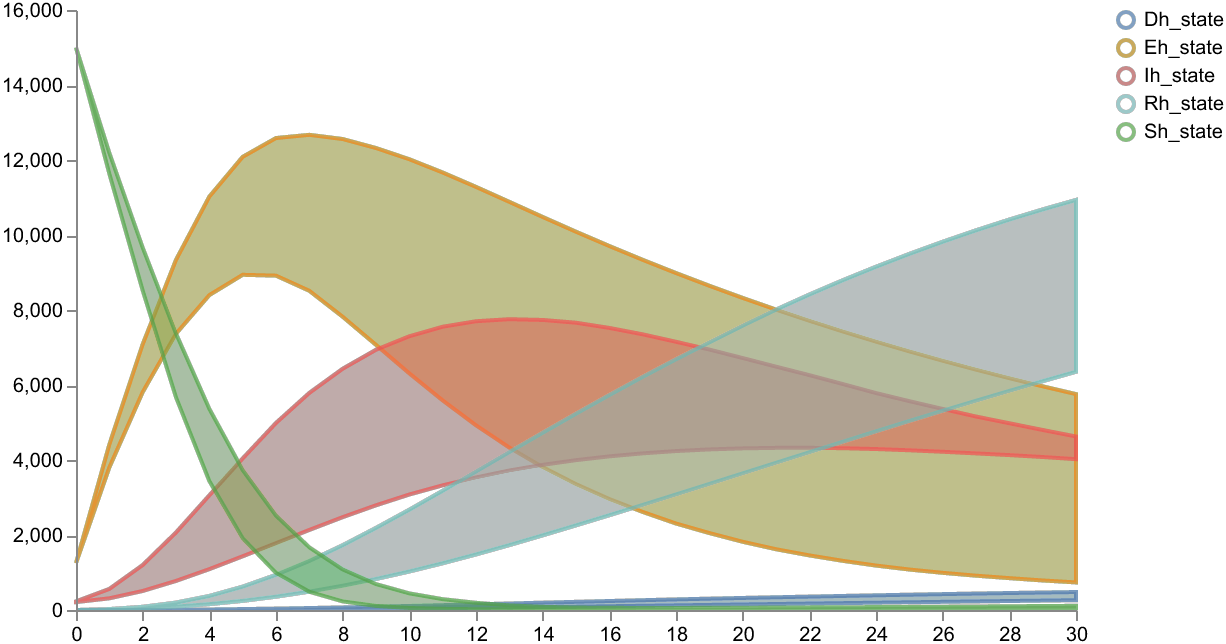

In [15]:
result1 = pyciemss.sample(model1, end_time, logging_step_size, num_samples, start_time=start_time)
# display(result1['data'].head())

# Plot results for human states
schema = plots.trajectories(result1["data"], keep=".*h_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

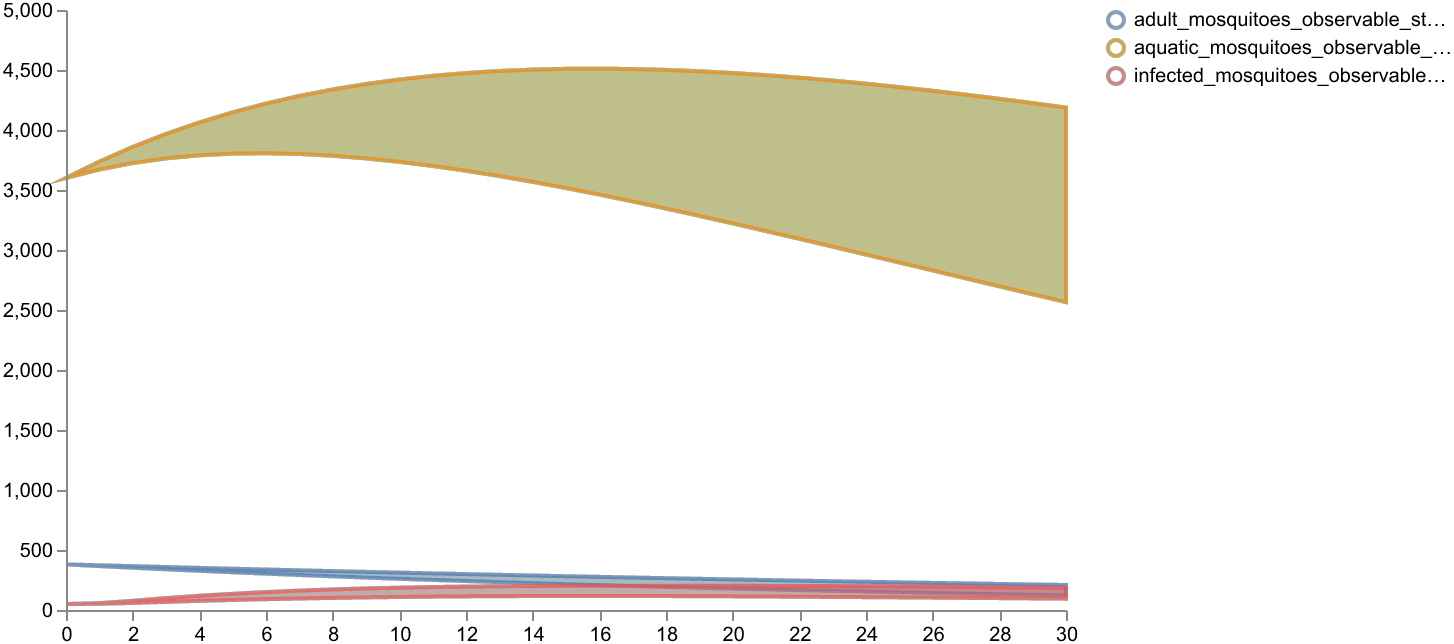

In [16]:
# Plot results for mosquito states
schema = plots.trajectories(result1["data"], keep=".*mosquitoes_observable_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

### Model intervention to simulate a campaign to eradicate mosquitoes in the aquatic state

This translates to increasing the parameter `zeta` from near zero to an ambitious 0.4 at time `t = 5.0`

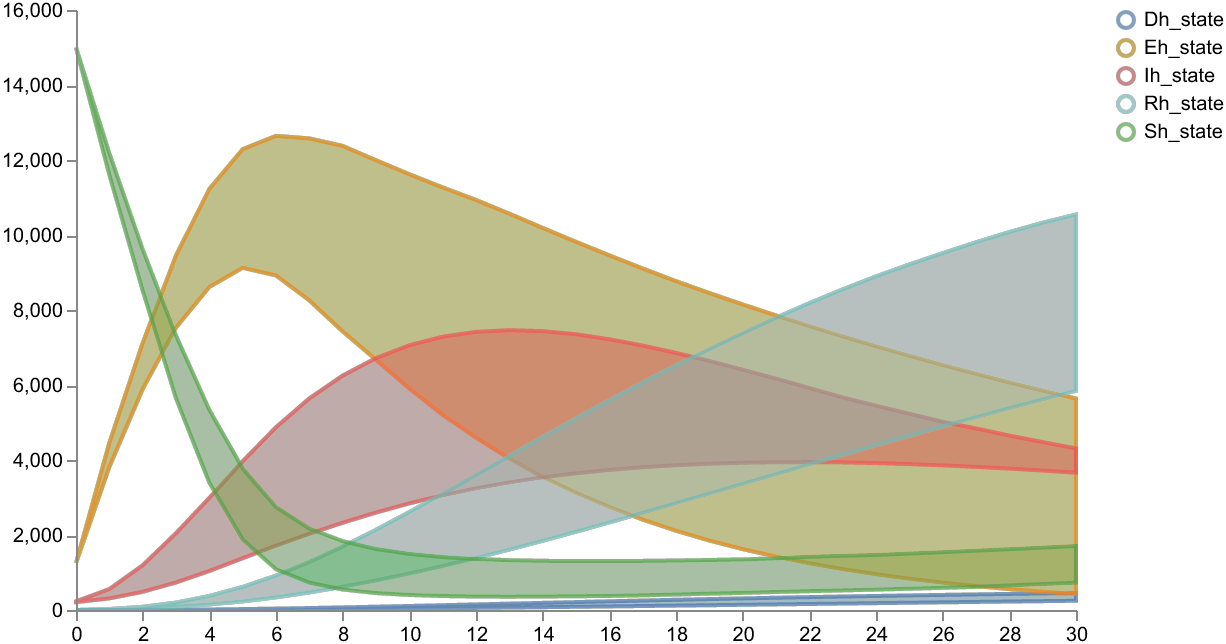

In [20]:
# intervened_result = pyciemss.sample(model1, end_time, logging_step_size, num_samples, start_time=start_time,
                                    # static_parameter_interventions={torch.tensor(5.0): {"zeta": torch.tensor(0.4)}})
# display(intervened_result["data"].head())

# Plot results for human states
schema = plots.trajectories(intervened_result["data"], keep=".*h_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

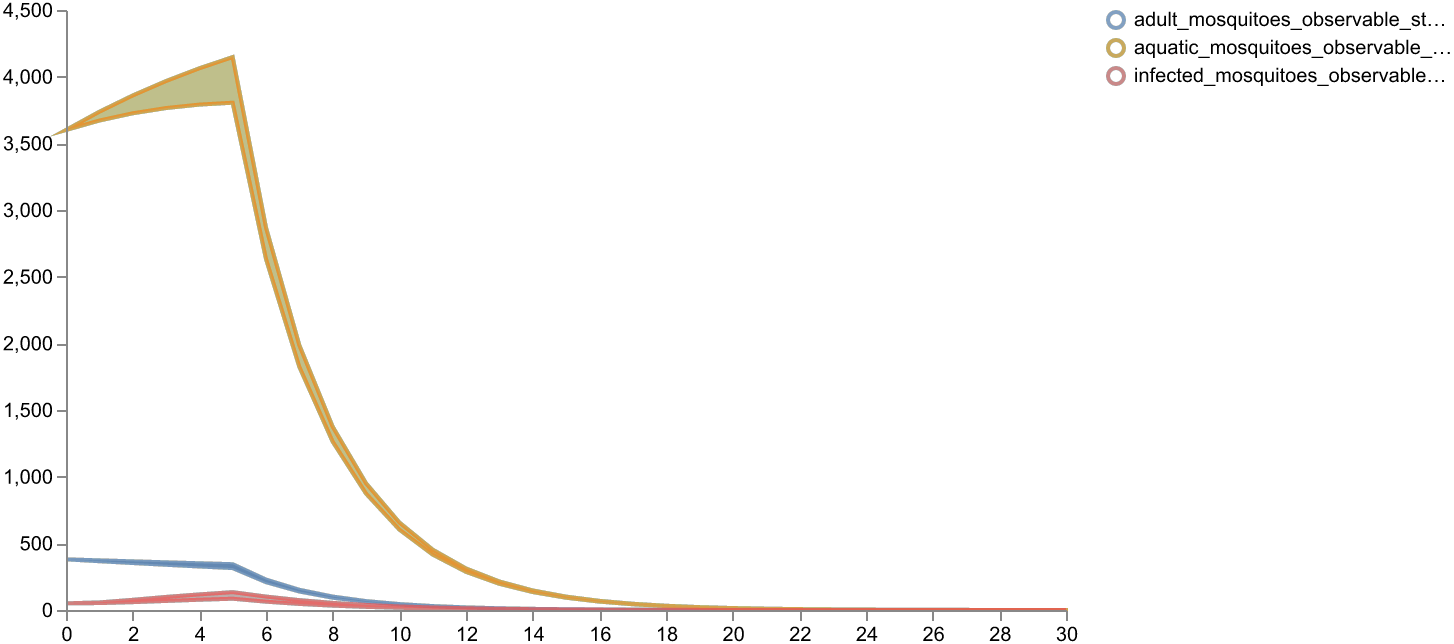

In [21]:
# Plot results for mosquito states
schema = plots.trajectories(intervened_result["data"], keep=".*mosquitoes_observable_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)